# Flight Route and Capacity Analysis

### Author: Rodrigo Andreatta da Costa
### Description:
This project aims to analyze flight routes, aircraft capacity, and traffic patterns using data from Delta tables stored in Amazon S3. By leveraging visualizations such as Sankey diagrams and treemaps, the project provides insights into flight capacity rates, major flight routes, and airport traffic distribution. The analysis can be used to support decision-making in route optimization, load management, and resource allocation for airlines and airports.


## Spark Session Configuration and AWS Setup

This script configures a Spark session to work with Amazon S3 and Delta Lake, while securely setting up AWS credentials.

1. **Importing Required Libraries**:
   - The necessary libraries are imported:
     - `os` for interacting with the environment variables.
     - `pandas` and `matplotlib.pyplot` for potential data manipulation and plotting.
     - `pyspark.sql` for creating and managing Spark sessions and data frames.
     - `pyspark.SparkConf` for configuring Spark with specific settings.
       

2. **`configure_spark_session` Function**:
   - This function configures and initializes a Spark session with the following key configurations:
     - **Delta Lake Support**: The `spark.jars.packages` configuration loads the Delta Lake package for Spark, allowing you to work with Delta tables.
     - **S3 Access**: The function uses the provided AWS access keys and region to set up S3 as a file system.
     - **Performance Tuning**: `spark.sql.shuffle.partitions` is set to `4` to optimize performance by controlling the number of partitions used in shuffle operations.
     - **Local Master**: Spark is set to run locally, utilizing all available cores (`local[*]`). This can be adjusted based on the environment (e.g., to run on a cluster).
       

3. **AWS Credentials Setup**:
   - The AWS access keys (`aws_access_key_id` and `aws_secret_access_key`) are stored in environment variables using `os.environ`. This helps avoid hardcoding credentials in the code, which is a better security practice.
   - The credentials are retrieved from environment variables using `os.getenv()`, ensuring they are securely accessed when configuring the Spark session.
     

4. **Initializing the Spark Session**:
   - After the credentials are set and retrieved, the `configure_spark_session` function is called, passing the AWS credentials and region as parameters.
   - The result is a Spark session configured to read from and write to S3 while supporting Delta Lake features.
     

This setup ensures that the Spark environment is ready to handle big data workflows, with secure access to S3 and optimized settings for performance.



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf

def configure_spark_session(aws_access_key, aws_secret_key, region):
    """
    Configure the Spark Session with necessary settings for Delta Lake and S3 access.
    - Adds Delta Lake support through Delta Catalog and extensions.
    - Configures S3 access with provided AWS credentials.
    - Sets Spark shuffle partitions and master mode.
    """
    conf = (
        SparkConf()
        .setAppName("FlightAnalysisApp")  # Adjust the app name accordingly
        .set("spark.jars.packages", "io.delta:delta-spark_2.12:3.2.0")
        .set("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
        .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .set("spark.hadoop.fs.s3a.access.key", aws_access_key)
        .set("spark.hadoop.fs.s3a.secret.key", aws_secret_key)
        .set("spark.hadoop.fs.s3a.endpoint", f"s3.{region}.amazonaws.com")
        .set("spark.sql.shuffle.partitions", "4")  # Tune partitioning for better performance
        .setMaster("local[*]")  # Run locally; adjust based on environment
    )
    
    return SparkSession.builder.config(conf=conf).getOrCreate()

region_name = 'sa-east-1'

os.environ['AWS_ACCESS_KEY_ID'] = aws_access_key_id
os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_access_key

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

spark = configure_spark_session(aws_access_key_id, aws_secret_access_key, region_name)

# Loading Data from S3 into Spark

The script below defines a function to load Parquet files from an Amazon S3 bucket into Spark and create temporary views for SQL querying. The key steps are as follows:

1. **`load_s3_to_spark` Function**:
   - The function takes four parameters: the Spark session, the S3 bucket name, the relative path to the Parquet files, and the name for the temporary view.
   - It constructs the full S3 path by combining the bucket name and relative path.
   - Using Spark's `read.parquet()` method, it loads the Parquet files from S3 into a Spark DataFrame.
   - A temporary view is created from the DataFrame using `createOrReplaceTempView()`. This allows SQL queries to be run on the data without having to reload it repeatedly.
   - A confirmation message is printed to indicate the successful creation of the temporary view.

2. **List of Tables to Load**:
   - A list named `tables` contains dictionaries, each of which provides details for loading a specific dataset from the S3 bucket.
   - For each dataset, the `bucket_name`, `relative_path`, and the `table_name` (which will be used as the temporary view name) are specified.

3. **Loop to Load All Tables**:
   - A loop iterates over the `tables` list, calling the `load_s3_to_spark` function for each table.
   - This dynamically loads all specified tables into Spark and creates corresponding temporary views for each one.
   
   This approach is modular and reusable, allowing new tables to be easily added to the list and loaded without modifying the core logic.


In [2]:
def load_s3_to_spark(spark: SparkSession, bucket_name: str, relative_path: str, table_name: str):
    """
    Load Parquet files from S3 into Spark and create a temporary view.
    - Loads data from S3 using the bucket and path.
    - Creates a temporary view to enable SQL queries on the loaded data.
    """
    s3_path = f"s3a://{bucket_name}/{relative_path}"
    df_spark = spark.read.parquet(s3_path)
    df_spark.createOrReplaceTempView(table_name)
    print(f"Temporary view '{table_name}' created successfully.")

tables = [
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/fact_tables/fact_bookings", "table_name": "fact_bookings"},
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/fact_tables/fact_boarding_passes", "table_name": "fact_boarding_passes"},
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/fact_tables/fact_flight_status", "table_name": "fact_flight_status"},
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/dimension_tables/dim_aircraft", "table_name": "dim_aircraft"},
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/dimension_tables/dim_airport", "table_name": "dim_airport"},
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/dimension_tables/dim_flight_route", "table_name": "dim_flight_route"},
    {"bucket_name": "postgres-repo", "relative_path": "gold/bookings/dimension_tables/dim_seat", "table_name": "dim_seat"}
]

# Load all tables
for table in tables:
    load_s3_to_spark(spark, table['bucket_name'], table['relative_path'], table['table_name'])

Temporary view 'fact_bookings' created successfully.
Temporary view 'fact_boarding_passes' created successfully.
Temporary view 'fact_flight_status' created successfully.
Temporary view 'dim_aircraft' created successfully.
Temporary view 'dim_airport' created successfully.
Temporary view 'dim_flight_route' created successfully.
Temporary view 'dim_seat' created successfully.


# Optimizing Delta Tables for Improved Query Performance

The script below defines a function to optimize Delta tables by applying **ZORDER** on specified columns. This optimization technique helps improve the performance of queries that frequently filter data based on those columns.

1. **`optimize_delta_table` Function**:
   - The function accepts three parameters:
     - `spark`: The active Spark session to run SQL commands.
     - `table_path`: The path to the Delta table on S3 that needs optimization.
     - `zorder_column`: The column on which the ZORDER optimization will be applied.
   - **ZORDER Optimization**: 
     - ZORDER is a technique used to organize data files in a Delta table based on the values of one or more columns. 
     - This optimization method is particularly useful for accelerating queries that filter large datasets using those columns.
   - **SQL Query**: The function constructs a SQL query to optimize the Delta table and applies ZORDER to the specified column. This query is executed via Spark's `spark.sql()` method.

2. **Optimizing Specific Tables**:
   - The script applies the optimization to two Delta tables:
     - **fact_bookings**: Optimized on the `flight_id` column.
     - **fact_flight_status**: Optimized on the `flight_no` column.
   - This ensures that future queries filtering by these columns will be faster, as the data is organized in a way that improves access efficiency.

By applying ZORDER to these tables, query performance is enhanced, especially for large datasets where filtering on `flight_id` or `flight_no` is common.


In [3]:
def optimize_delta_table(spark: SparkSession, table_path: str, zorder_column: str):
    """
    Optimize a Delta table by applying ZORDER on a specified column to improve query performance.
    - ZORDER organizes the data files for faster query access based on the specified column.
    """
    query = f"""
        OPTIMIZE delta.`{table_path}`
        ZORDER BY ({zorder_column})
    """
    spark.sql(query)

# Optimize the fact_bookings and fact_flight_status tables
optimize_delta_table(spark, "s3a://postgres-repo/delta/bookings/fact_tables/fact_bookings", "flight_id")
optimize_delta_table(spark, "s3a://postgres-repo/delta/bookings/fact_tables/fact_flight_status", "flight_no")

# Query for Analyzing Flight Delays

The SQL query below is designed to analyze flight delays and calculate the percentage of delayed flights for each route. It operates in the following steps:

1. **Common Table Expression (CTE) - `flight_delays`**:
   - The query begins with a CTE that calculates whether each flight is delayed by 15 minutes (900 seconds) or more.
   - The `unix_timestamp` function is used to calculate the difference between the `actual_arrival` and `scheduled_arrival` times.
   - If the difference is greater than or equal to 900 seconds, the flight is considered delayed (`is_late = 1`), otherwise it is considered on time (`is_late = 0`).
   - Flights with `NULL` values for `actual_arrival` are excluded from the analysis.

2. **Main Query**:
   - The main query calculates the total number of flights (`total_flights`) and the total number of delayed flights (`late_flights`) for each flight number (`flight_no`).
   - The late percentage (`late_perc`) is calculated as `(late_flights / total_flights) * 100`.

3. **Route Information**:
   - The query joins the results of the CTE with the `dim_flight_route` table to retrieve the departure and arrival airports for each flight.
   - A string concatenating the departure and arrival airports (`route_str`) is created for clearer presentation of the flight routes.

4. **Ordering and Limiting Results**:
   - The results are ordered by `late_perc` in descending order, meaning the routes with the highest percentage of delayed flights will appear at the top.
   - The query limits the results to the top 25 routes with the highest percentage of delayed flights.

The final output provides the flight number, route string (departure to arrival), total number of flights, number of delayed flights, the percentage of delayed flights, and the individual departure and arrival airports. This data can be used to identify routes with high rates of delays.


In [4]:
sql_query = """
    WITH flight_delays AS (
        SELECT 
            flight_no,
            CASE 
                WHEN (unix_timestamp(actual_arrival) - unix_timestamp(scheduled_arrival)) >= 900 THEN 1
                ELSE 0
            END AS is_late
        FROM fact_flight_status
        WHERE actual_arrival IS NOT NULL
    )
    SELECT 
        z.flight_no, 
        CONCAT(departure_airport, ' -> ', arrival_airport) AS route_str, 
        total_flights, 
        late_flights, 
        (late_flights / total_flights) * 100 AS late_perc, 
        departure_airport, 
        arrival_airport
    FROM (
        SELECT 
            flight_no,
            COUNT(*) AS total_flights,
            SUM(is_late) AS late_flights        
        FROM flight_delays
        GROUP BY flight_no    
    ) z
    INNER JOIN dim_flight_route r ON r.flight_no = z.flight_no
    ORDER BY late_perc DESC
    limit 25
"""

df_flight_delays = spark.sql(sql_query)

# Plotting Late Flight Percentage by Departure Airport

The script below defines a function to create a **horizontal bar chart** that visualizes the percentage of late flights for each departure airport. This type of graph is useful for identifying airports with the highest rates of delayed departures, allowing for insights into the operational efficiency or challenges at those airports.

### Explanation:

1. **Input Data**:
   - The function accepts a Spark DataFrame (`result`) containing information about the percentage of late flights (`late_perc`) and the corresponding departure airports (`departure_airport`).
   - The data is converted to a Pandas DataFrame for easy plotting using `matplotlib`.

2. **Data Sorting**:
   - The DataFrame is sorted in descending order based on `late_perc`, so the airports with the highest percentage of delayed flights appear at the top of the chart.

3. **Horizontal Bar Chart**:
   - A **horizontal bar chart** is plotted, where each bar represents a departure airport, and the length of the bar corresponds to the percentage of late flights from that airport.
   - The x-axis represents the **percentage of late flights** (`late_perc`), while the y-axis lists the **departure airports**.
   - This graph provides a clear visual representation of which airports are experiencing more delays.

4. **Use Case**:
   - The graph is particularly useful for airline operations teams, airport management, or aviation analysts who want to:
     - Identify problem areas where flight delays are frequent.
     - Compare the performance of different airports in terms of on-time departures.
     - Focus operational improvements or allocate resources to the airports with the highest delay percentages.


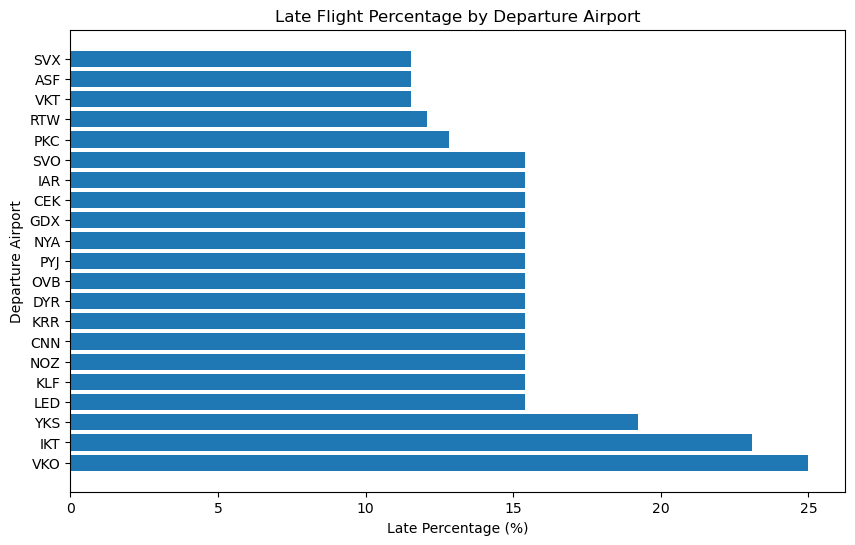

In [5]:
def plot_late_flight_percentage(result: DataFrame):
    """
    Create a horizontal bar chart of late flight percentages by departure airport.
    """
    df = result.select("departure_airport", "late_perc").toPandas()
    df = df.sort_values(by="late_perc", ascending=False)
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(df['departure_airport'], df['late_perc'])
    plt.xlabel('Late Percentage (%)')
    plt.ylabel('Departure Airport')
    plt.title('Late Flight Percentage by Departure Airport')
    plt.show()


# Plot the late flight percentage chart
plot_late_flight_percentage(df_flight_delays)

# Aircraft Capacity and Flight Capacity Rate Analysis

The script below consists of two key steps aimed at calculating the aircraft capacity and determining the average capacity utilization rate for each flight. These metrics will be used as data sources for visualizations or further analysis.

### Step 1: Calculate Aircraft Capacity (`dim_aircraft_capacity`)

1. **Purpose**:
   - The goal of this step is to calculate the **capacity** of each aircraft model by counting the total number of seats available (`COUNT(1) AS capacity`) for each flight.

2. **SQL Query**:
   - The query joins the `fact_flight_status` table with the `dim_aircraft` and `dim_seat` tables to retrieve the **aircraft code**, **model**, and the corresponding number of seats.
   - **Group By**: The results are grouped by the flight ID, aircraft code, and model, allowing the calculation of the total seat capacity per flight.

3. **Output**:
   - The result of this query is stored in a Spark DataFrame (`dim_aircraft_capacity`), which is also saved as a **temporary view** in Spark SQL for use in subsequent queries.

### Step 2: Calculate Average Flight Capacity Rate (`fact_flight_capacity_avg`)

1. **Purpose**:
   - The aim here is to calculate the **average capacity rate** (i.e., the percentage of seats occupied) for each flight number (`flight_no`).

2. **SQL Query**:
   - The query calculates the capacity rate by comparing the number of bookings (`COUNT(1)`) for each flight to the total seat capacity of the corresponding aircraft (`c.capacity`), which was calculated in Step 1.
   - **Inner Query**: 
     - Joins the `fact_bookings`, `fact_flight_status`, and `dim_aircraft_capacity` tables to get the flight ID, number of bookings, and aircraft capacity.
     - The capacity rate is calculated as `COUNT(1) / c.capacity * 100` to express it as a percentage.
   - **Outer Query**:
     - Groups by flight number and calculates the **average capacity rate** across multiple flights using `ROUND(AVG(capacity_rate), 2)`.
     - The query filters flights to include only those with at least 10 records (`HAVING COUNT(1) >= 10`).
     - The results are ordered by the average capacity rate in descending order (`ORDER BY capacity_rate_avg DESC`).

3. **Output**:
   - The final results are saved in a Spark DataFrame (`fact_flight_capacity_avg`) and also as a **temporary view** for further use in reporting or visualization.


In [6]:
# Step 1: Calculate dim_aircraft_capacity

# Optimized query to calculate aircraft capacity based on seats
sql_query = """
    SELECT s.flight_id, a.aircraft_code, a.model, COUNT(1) AS capacity
    FROM delta.`s3a://postgres-repo/delta/bookings/fact_tables/fact_flight_status` s
    INNER JOIN dim_aircraft a ON s.aircraft_code = a.aircraft_code
    INNER JOIN dim_seat t ON t.aircraft_code = a.aircraft_code
    GROUP BY s.flight_id, a.aircraft_code, a.model
"""

# Run the query and create the dim_aircraft_capacity temporary view
dim_aircraft_capacity = spark.sql(sql_query)
dim_aircraft_capacity.createOrReplaceTempView('dim_aircraft_capacity')

# Step 2: Calculate fact_flight_capacity_avg

# Optimized query to calculate the average capacity rate for flights
sql_query = """
    SELECT flight_no, ROUND(AVG(capacity_rate), 2) AS capacity_rate_avg
    FROM (
        SELECT s.flight_no, b.flight_id, COUNT(1) / c.capacity * 100 AS capacity_rate
        FROM delta.`s3a://postgres-repo/delta/bookings/fact_tables/fact_bookings` b
        INNER JOIN delta.`s3a://postgres-repo/delta/bookings/fact_tables/fact_flight_status` s 
            ON s.flight_id = b.flight_id
        INNER JOIN dim_aircraft_capacity c 
            ON c.flight_id = b.flight_id   
        GROUP BY s.flight_no, b.flight_id, c.capacity    
    )
    GROUP BY flight_no
    HAVING COUNT(1) >= 10
    ORDER BY capacity_rate_avg DESC
"""

# Run the query and show the top results
fact_flight_capacity_avg = spark.sql(sql_query)
fact_flight_capacity_avg.createOrReplaceTempView('fact_flight_capacity_avg')

# Flight Capacity Rate Treemap Visualization

This script uses **Plotly Express** to create a **treemap** that visualizes the average flight capacity rates. Each square represents a flight, sized and colored by its capacity rate.

### Key Steps:

1. **Custom Hover Info**:
   - Custom hover text displays flight number and capacity rate.

2. **Treemap**:
   - Flights are displayed as squares, sized by capacity rate (`capacity_rate_avg`) and colored from **red (low)** to **green (high)** using a continuous scale.
   - The hierarchy is based on `flight_no`, and the color bar provides a quick reference to capacity rates.

### Use Case:
- The treemap provides a quick visual comparison of flight occupancy, helping identify high and low capacity routes.


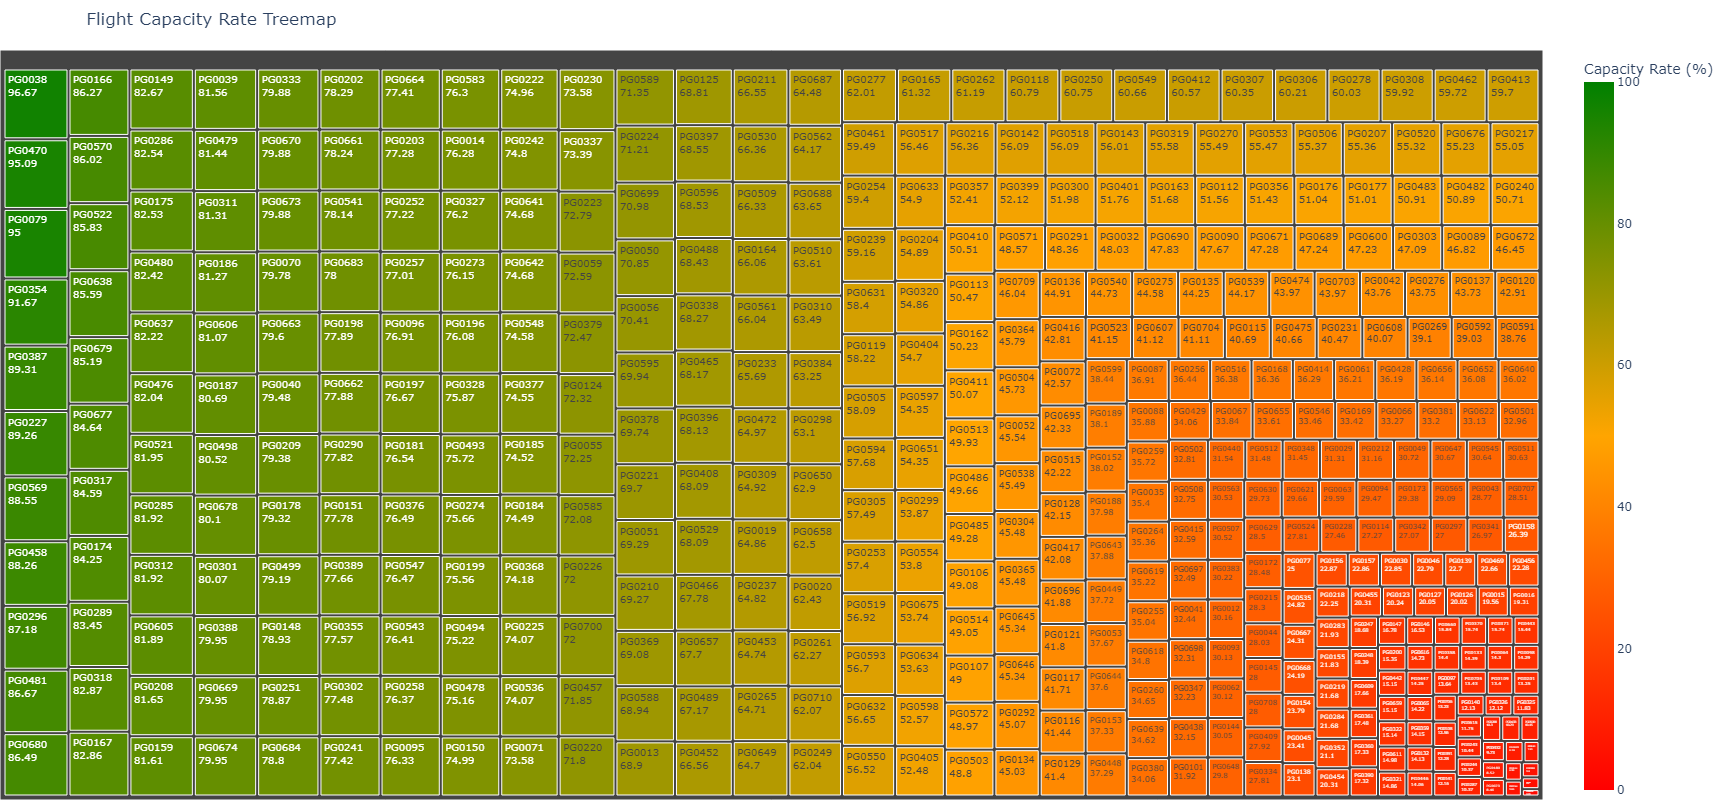

In [10]:
import plotly.express as px
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = fact_flight_capacity_avg.select("flight_no", "capacity_rate_avg").toPandas()

# Create a new column to customize the hover data
pandas_df['hover_info'] = pandas_df.apply(lambda x: f"Flight: {x['flight_no']}<br>Capacity Rate: {x['capacity_rate_avg']:.2f}%", axis=1)

# Create the treemap using Plotly Express
fig = px.treemap(
    pandas_df,
    path=['flight_no'],  # This defines the hierarchy (just flight number in this case)
    values='capacity_rate_avg',  # The size of each square
    color='capacity_rate_avg',  # Color by the capacity rate
    hover_data={'capacity_rate_avg': False, 'hover_info': True},  # Add custom hover info
    color_continuous_scale=[(0, "red"), (0.5, "orange"), (1, "green")],  # Custom color scale
    range_color=[0, 100]  # Set the color range from 0 to 100%
)

# Update the hover template to show custom hover text
fig.update_traces(
    hovertemplate='%{customdata[0]}',
    textinfo="label+value",  # Display both flight number and value
    textfont_size=10  # Reduce the text size to allow more elements
)

# Set layout and title with smaller margins and increased height
fig.update_layout(
    title="Flight Capacity Rate Treemap",
    width=1200,
    height=800,
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title="Capacity Rate (%)",
    )
)

# Display the treemap
fig.show()


# Data Preparation for Sankey Diagram

The query below prepares data for a **Sankey diagram** by analyzing flight routes. The result shows the top 100 most frequent routes, connecting departure and arrival airports.

### Key Steps:

1. **Joins**:
   - The `fact_bookings` table is joined with the `fact_flight_status` and `dim_flight_route` tables to gather information on flight routes.

2. **Grouping and Counting**:
   - The query groups the data by `departure_airport` and `arrival_airport`, counting how many flights occurred on each route.

3. **Top 100 Routes**:
   - The result is ordered by the number of flights (`count`) and limited to the top 100 routes.

### Use Case:
- This dataset will be used to create a Sankey diagram, showing the flow of flights between airports. The width of the links between airports will represent the number of flights, highlighting the busiest routes.


In [8]:
sql_query = """
    SELECT dr.departure_airport, dr.arrival_airport, count(1) count 
    FROM delta.`s3a://postgres-repo/delta/bookings/fact_tables/fact_bookings` b
    INNER JOIN delta.`s3a://postgres-repo/delta/bookings/fact_tables/fact_flight_status` s 
        ON s.flight_id = b.flight_id    
    INNER JOIN dim_flight_route dr 
        ON dr.flight_no = s.flight_no
    GROUP BY dr.departure_airport, dr.arrival_airport
    ORDER BY 3 DESC
    LIMIT 100
"""

df_routes = spark.sql(sql_query)

# Flight Routes Sankey Diagram for Analysis

The Sankey diagram below visualizes the flow of flights between departure and arrival airports, providing insights into the busiest routes and traffic distribution across the network.

### Why Use a Sankey Diagram in Analysis?

1. **Visualizing Route Traffic**:
   - The Sankey diagram makes it easy to see which airports are connected by the largest number of flights. The **width of the links** between nodes (airports) is proportional to the number of flights, highlighting major hubs and key routes.
   
2. **Identifying Bottlenecks or Overload**:
   - Airports with multiple thick links may indicate busy hubs or potential bottlenecks in air traffic, helping analysts understand how resources (planes, gates, staff) are distributed.
   
3. **Understanding Traffic Patterns**:
   - The diagram shows how traffic flows from one airport to another, helping to identify direct routes versus more complex connections that might involve multiple stops.
   
4. **Strategic Route Planning**:
   - Airlines and airports can use the diagram to identify **underutilized routes** or opportunities for expanding capacity on high-demand connections.

### Key Steps in the Script:
- **Data Preparation**: The departure and arrival airports are mapped to unique indices and combined to form the nodes in the diagram.
- **Link Generation**: The flow (link) between airports is determined by the number of flights, with color and width emphasizing the volume of traffic.

This Sankey diagram allows analysts to visually assess the connectivity and traffic between airports, helping in decision-making regarding capacity optimization, route planning, and resource allocation.


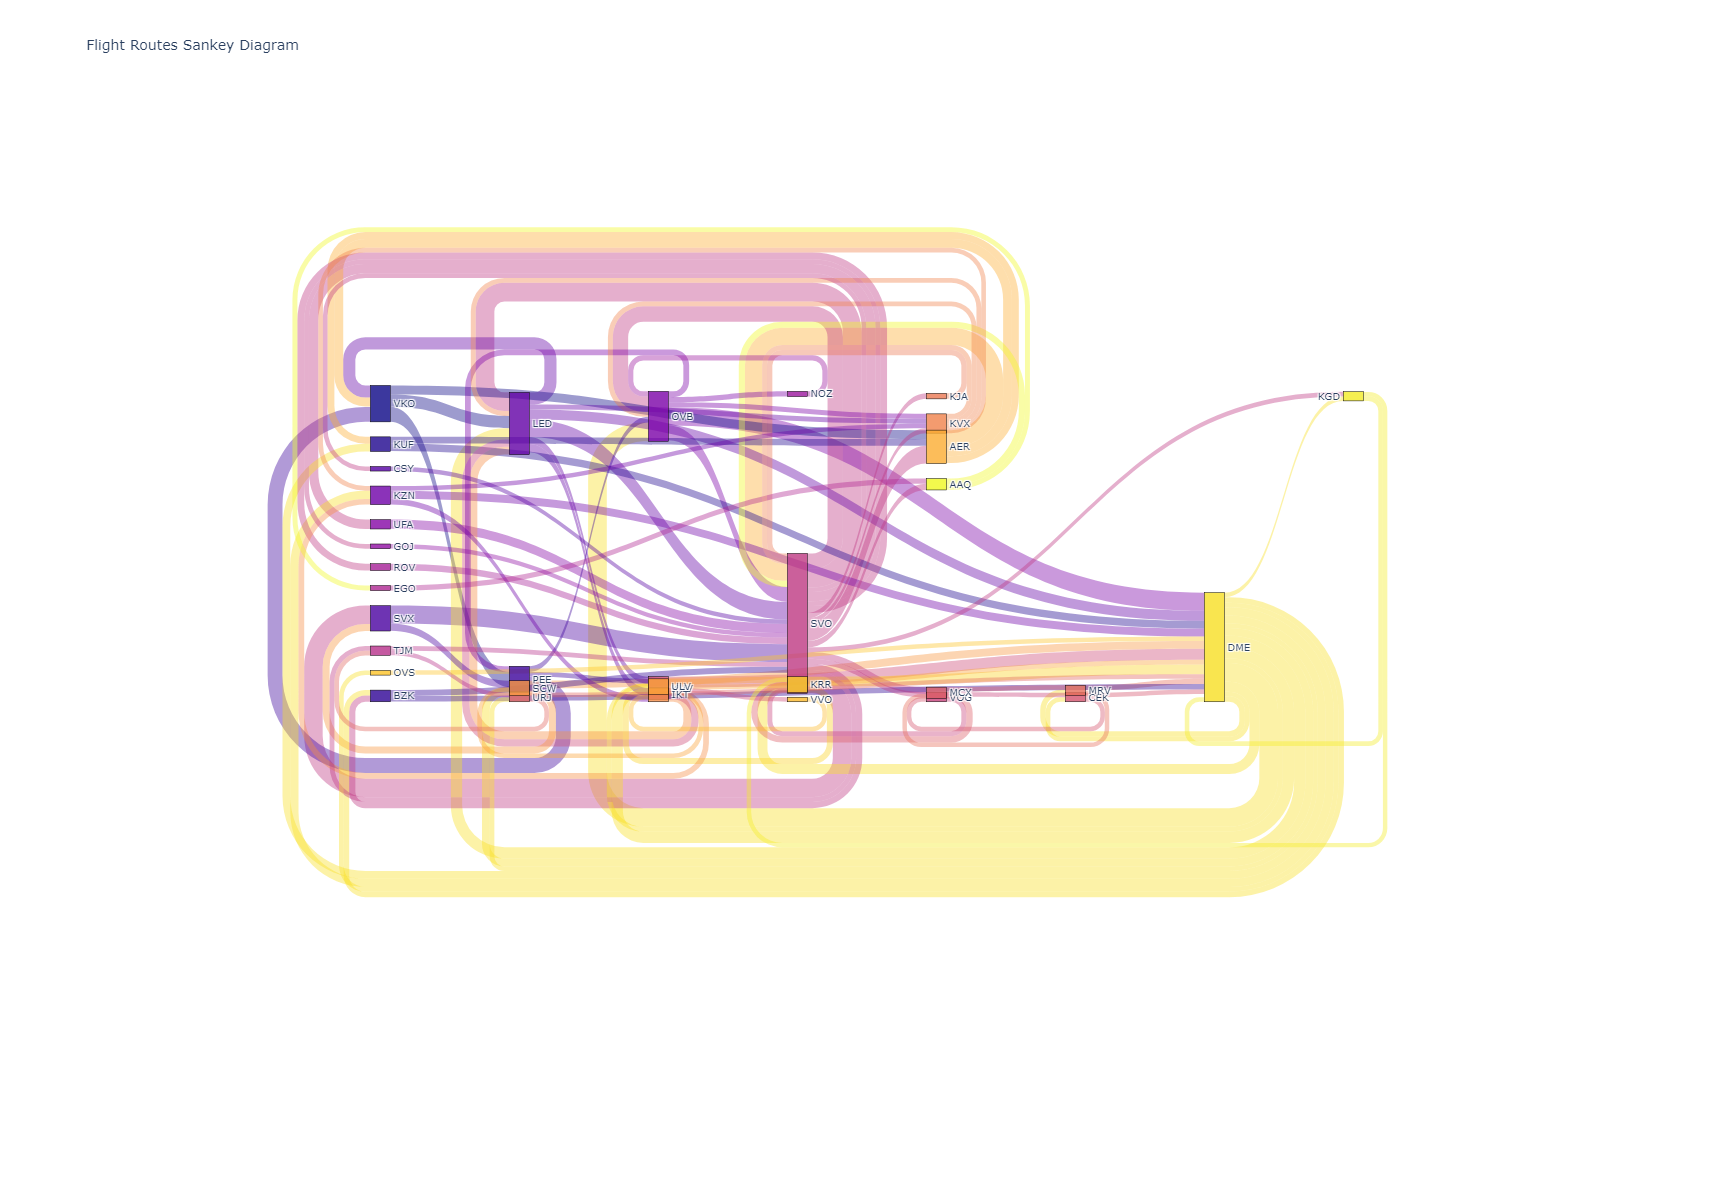

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# Generate color rule for links based on source colors
def generate_link_colors(source_indices, node_colors, opacity=0.4):
    return [node_colors[src].replace("0.8", str(opacity)) for src in source_indices]

# Assuming `df` is your Spark DataFrame
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = df_routes.select("departure_airport", "arrival_airport", "count").toPandas()

# Extract unique airports (nodes) from departure and arrival airports
departure_airports = pandas_df['departure_airport'].tolist()
arrival_airports = pandas_df['arrival_airport'].tolist()

# Combine all unique airports for nodes in the Sankey diagram
all_airports = list(set(departure_airports + arrival_airports))

# Step 3: Create mappings for the airport nodes (label -> index)
airport_to_index = {airport: idx for idx, airport in enumerate(all_airports)}

# Step 4: Prepare the source, target, and values for the Sankey diagram
source = [airport_to_index[departure] for departure in pandas_df['departure_airport']]
target = [airport_to_index[arrival] for arrival in pandas_df['arrival_airport']]
values = pandas_df['count'].tolist()

# Step 5: Use a colormap to generate colors for nodes
colormap = plt.get_cmap('plasma')
node_colors = [f"rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, 0.8)" for r, g, b, _ in colormap(np.linspace(0, 1, len(all_airports)))]

# Step 6: Generate link colors based on the source node colors
link_colors = generate_link_colors(source, node_colors)

# Step 7: Create and plot the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_airports,
        color=node_colors
    ),
    link=dict(
        source=source,
        target=target,
        value=values,
        color=link_colors
    )
))

# Update layout to make the diagram larger
fig.update_layout(
    title_text="Flight Routes Sankey Diagram",
    font_size=10,   
    height=1200,
    width=2000
)

# Show the Sankey diagram
fig.show()



#### Dataset:
The dataset used in this project was obtained from [PostgresPro Demo Database](https://postgrespro.com/community/demodb).